In [ ]:
import urllib.request
from tqdm import tqdm
import os 
import glob
import numpy as np
import pandas as pd

In [ ]:
class_names = ['sun', 'face', 'ant', 'apple', 'bird']

In [ ]:
# download dataset

for label in tqdm(class_names):
  endpoint = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{}.npy'
  dataset_path = 'dataset/{}.npy' 
  urllib.request.urlretrieve(endpoint.format(label), dataset_path.format(label))

100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


In [ ]:
files = glob.glob(os.path.join('dataset/', '*.npy'))

x = np.empty([0, 784])
y = np.empty([0])
lbls = {}

for id, file in tqdm(enumerate(files)):
  arrs = np.load(file)[0: 20000]  # get only 100000 records per each
  labels = np.full(arrs.shape[0], id)  # make array with labels
  
  x = np.concatenate((x, arrs), axis=0)
  y = np.concatenate((y, labels), axis=0)

  lbls[id] = file.split('/')[-1].split('.')[0]
x.shape, y.shape
print(lbls)

5it [00:00,  5.27it/s]

{0: 'sun', 1: 'apple', 2: 'face', 3: 'bird', 4: 'ant'}


In [ ]:
df = pd.DataFrame({'image': list(x), 'label': y})
df['label'] = df['label'].astype(int)

In [ ]:
# shuffle dataframe
from sklearn import utils


df = utils.shuffle(df).reset_index(drop=True)
df.head()

,image,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [ ]:
from sklearn.model_selection import train_test_split

# independant dependant var
x = df['image'].values
y = df['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

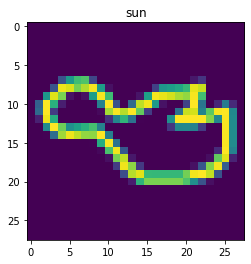

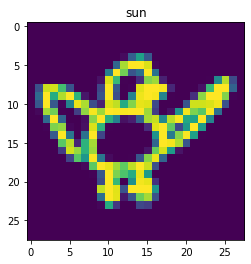

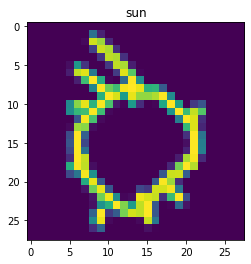

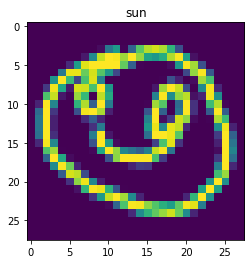

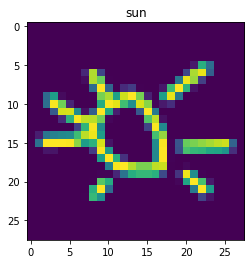

In [ ]:
# show random images from training set
import matplotlib.pyplot as plt
from random import randint
for i in range(5):
  id = randint(0, x_train.shape[0])
  plt.imshow(x_train[id].reshape(28, 28))
  idx = (-y_train[id]).argsort()[0]
  plt.title(lbls[idx])
  plt.show()


Preprocessing

In [ ]:
x_train = np.array(x_train.tolist()).reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = np.array(x_test.tolist()).reshape(x_test.shape[0], 28, 28, 1).astype('float32')

x_train.shape, x_test.shape


((70000, 28, 28, 1), (30000, 28, 28, 1))

In [ ]:
# normalizing
x_train /= 255
x_test /= 255

In [ ]:
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train, len(class_names))
y_test = tf.keras.utils.to_categorical(y_test, len(class_names))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=1e-4),
             metrics=['accuracy']
             )

In [ ]:
hist = model.fit(
    x_train, y_train,
    epochs=10,
    verbose=1,
    validation_data=(x_test, y_test),
    )

Epoch 1/10
2188/2188 [==============================] - 46s 8ms/step - loss: 0.5036 - accuracy: 0.8242 - val_loss: 0.2837 - val_accuracy: 0.9069
Epoch 2/10
2188/2188 [==============================] - 19s 9ms/step - loss: 0.2962 - accuracy: 0.9050 - val_loss: 0.2330 - val_accuracy: 0.9246
Epoch 3/10
2188/2188 [==============================] - 20s 9ms/step - loss: 0.2561 - accuracy: 0.9190 - val_loss: 0.2082 - val_accuracy: 0.9324
Epoch 4/10
2188/2188 [==============================] - 18s 8ms/step - loss: 0.2312 - accuracy: 0.9257 - val_loss: 0.1970 - val_accuracy: 0.9358
Epoch 5/10
2188/2188 [==============================] - 20s 9ms/step - loss: 0.2126 - accuracy: 0.9328 - val_loss: 0.1816 - val_accuracy: 0.9409
Epoch 6/10
2188/2188 [==============================] - 18s 8ms/step - loss: 0.2010 - accuracy: 0.9360 - val_loss: 0.1761 - val_accuracy: 0.9422
Epoch 7/10
2188/2188 [==============================] - 20s 9ms/step - loss: 0.1901 - accuracy: 0.9398 - val_loss: 0.1649 - val_ac

In [ ]:
import matplotlib.pyplot as plt

def gen_graph(history, title):
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  plt.show()

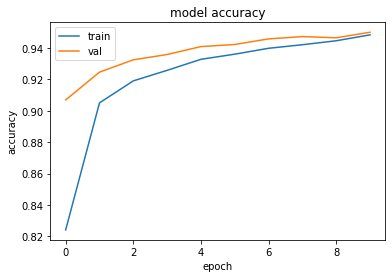

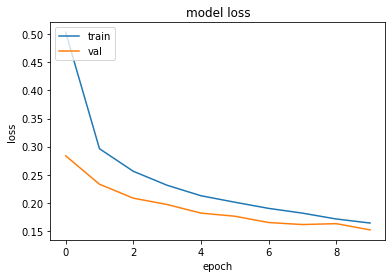

In [ ]:
gen_graph(hist, 'Doodle CNN')

In [ ]:
model.save('model.h5')

In [ ]:
import cv2

def get_processed_input_img(image_path, size=28):
  test_img =  cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  kernel = np.ones((3, 3), np.uint8)
  test_img = cv2.erode(test_img, kernel, iterations=1)
#   print(test_img.shape)
  test_img = cv2.resize(test_img, dsize=(size, size), interpolation=cv2.INTER_AREA)
  thresh = 200
  test_img = cv2.threshold(test_img, thresh, 255, cv2.THRESH_BINARY_INV)[1]
#   cv2.imwrite('1s.png', test_img)
  # plt.imshow(test_img)
  test_img = test_img.reshape((1, size, size, 1)).astype(np.float32)
  
  return test_img/255

img = get_processed_input_img('/content/f.png')


# print(x_test[9], '\n\n\n\n')
print(img)


[[[[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [1.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   [0.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [0.]
   [0.]
   [1.]


In [ ]:
lbls

{0: 'sun', 1: 'apple', 2: 'face', 3: 'bird', 4: 'ant'}

In [ ]:
pred = model.predict(img)
pred

array([[2.6633335e-05, 2.5511348e-05, 9.9714798e-01, 2.7915412e-03,
        8.2757133e-06]], dtype=float32)

In [ ]:
best_5 = (-pred).argsort()[0]
best_5

array([2, 3, 0, 1, 4])

In [ ]:
print([lbls[i] for i in best_5])

['face', 'bird', 'sun', 'apple', 'ant']


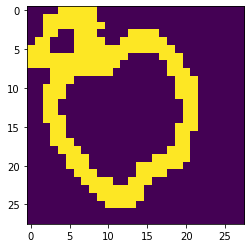

[0.09978314 0.36038414 0.35983133 0.14862826 0.03137317]
[1 2 3 0 4]
['apple', 'face', 'bird', 'sun', 'ant']


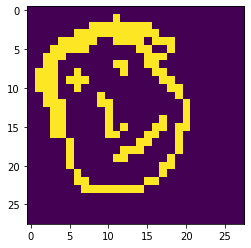

[2.6633335e-05 2.5511348e-05 9.9714798e-01 2.7915412e-03 8.2757133e-06]
[2 3 0 1 4]
['face', 'bird', 'sun', 'apple', 'ant']


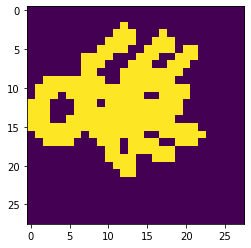

[0.0677975  0.00979589 0.07284924 0.18902802 0.6605294 ]
[4 3 2 0 1]
['ant', 'bird', 'face', 'sun', 'apple']


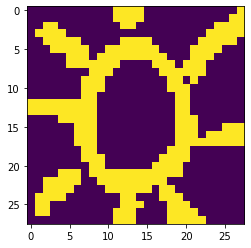

[9.8430401e-01 7.8218363e-07 3.0488170e-06 1.5257219e-02 4.3490474e-04]
[0 3 4 2 1]
['sun', 'bird', 'ant', 'face', 'apple']


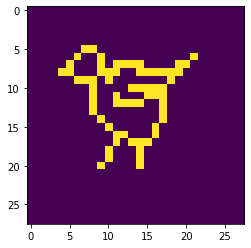

[7.9868966e-01 5.6194217e-04 2.0808063e-02 1.4009382e-01 3.9846558e-02]
[0 3 4 2 1]
['sun', 'bird', 'ant', 'face', 'apple']


In [ ]:
imgs = ['apple', 'f', 'ant', 'sun', 'bird']


for i in imgs:
  img = get_processed_input_img('/content/{}.png'.format(i))

  plt.imshow((img * 255).reshape(28, 28))
  plt.show()

  pred = model.predict(img)[0]
  print(pred)
  best_5 = (-pred).argsort()
  print(best_5)
  print([lbls[i] for i in best_5])